# Sequence evolution walkthrough
**Authorship:**
Adam Klie (last updated: *07/16/2023*)
***
**Description:**
This notebook is meant to serve as a guide for performing an *in silico* evolution analysis with a trained PyTorch model using SeqExplainer. The notebook will walk through the steps of performing the analysis and interpreting the results.
***

# Background
Generating functional DNA sequences is a huge research area in synthetic biology. From controlling plant behavior to , the possibilities are huge. Machine learning models offer signfiicant promise as a tool for generating functional sequences, but this area is still new. With SeqExplainer, we aim to give users tools for exploring the sequence space around a trained model. We implement the simplest form of this approach that iteratively evolves a sequence by greedily inserting the mutation with the largest predicted impact at each iteration. Starting with an initial sequence (e.g. random, shuffled, etc.), this strategy can be used to evolve synthetic functional sequences. This style of analysis is a promising direction for further research, and can also serve as an extension of ISM for validating that the model has learned representations that resemble motifs.

# Running an *in silico* evolution
Let's run an evolution on the model trained in the EUGENe paper for prediction of the regulatory activity of plant promoters. We can download the model weights using the following code:

## Load in a model
 - TODO: Make the model checkpoint available somewhere

In [159]:
# General purpose imports
import os
import torch
import numpy as np

In [99]:
from eugene import models

In [100]:
# Load up the model form the checkpoint
model_file = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21/cnn/leaf_trial_4/checkpoints/epoch=9-step=4580.ckpt"
model_arch = models.load_config(config_path="/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21/cnn.yaml")
model = models.SequenceModule.load_from_checkpoint(model_file, arch=model_arch.arch)

[rank: 0] Global seed set to 4


## Generate some random sequences
We next need to create the sequences we want to evolve. In this notebook, we will generate random sequences as our starting material. We can use SeqPro functions to do this.

In [112]:
import seqpro as sp

In [107]:
# Generate 10 sequences of length 170
random_seqs = sp.random_seqs(
    shape=(10, 170),
    alphabet=sp.alphabets.DNA
)

In [116]:
# One-hot encode the sequences
random_seqs = sp.ohe(random_seqs, alphabet=sp.alphabets.DNA).transpose(0, 2, 1)

## Perform the evolution
Now that we have some baseline sequences, we can perform the evolution. This is done by iteratively performing a *in silico* saturation mutagenesis and selecting the mutation that most increases the predicted activity.

In [114]:
from seqexplainer import evolution
from tqdm.auto import tqdm  # progress bar to use for evolution

In [135]:
# Takes about 2 minutes to do 5 rounds of evolution on 10 sequences
rounds = 5
evolved_seqs = []
deltas = np.zeros((len(random_seqs), rounds))
mutation_pos = []
for i, random_seq in tqdm(enumerate(random_seqs), total=random_seqs.shape[0], desc="Evolving sequences"):
    evolved_res = evolution(
        model=model,
        X=random_seq,
        rounds=rounds,
    )
    evolved_seqs.append(evolved_res[0])
    deltas[i, :] = deltas[i, :] + evolved_res[1]
    mutation_pos.append(evolved_res[2])
X_evolved = torch.tensor(np.array(evolved_seqs), dtype=torch.float32)
mutation_pos = np.array(mutation_pos)

Evolving sequences:   0%|          | 0/10 [00:00<?, ?it/s]

## Plot the score change over rounds
Let's visualize the results by plotting the violin plots predicted activities over each round of evolution. The easiest way to do this is to first create a dataframe with the results.

In [ ]:
import pandas as pd

In [129]:
scores = {}
scores[0] = model.predict(random_seqs, batch_size=32, verbose=False).detach().cpu().numpy().squeeze()
for i in range(1, rounds+1):
    scores[i] = scores[i-1] + deltas[:, i-1]
score_df = pd.DataFrame(scores)
score_df.columns = ["round_{}".format(i) for i in range(rounds+1)]
score_df.head()

Now we can easily plot with seaborn

In [147]:
import seaborn as sns

Text(0, 0.5, 'Score')

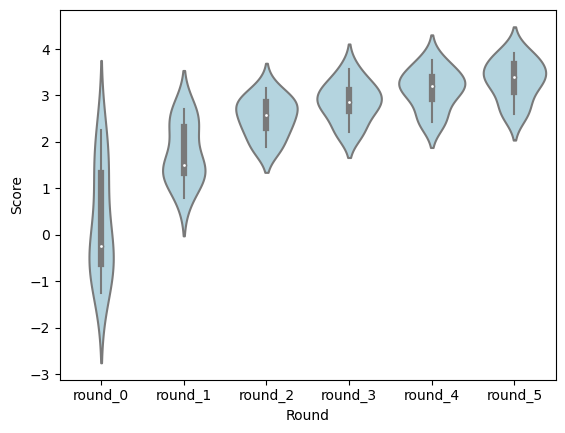

In [152]:
# Make a violinplot of the scores at each round
g = sns.violinplot(data=score_df, color="lightblue")
g.set_xlabel("Round")
g.set_ylabel("Score")

## Plot the differences in attribution logos
Another interesting visualization one can use is to plot the before and after attrribution logos. This allows us to see what features are being selected for by the model.

In [160]:
from seqexplainer import attribute

In [154]:
# Get the attributions for the random and evolved sequences
random_attrs = attribute(
    model=model,
    inputs=X_random,
    method="InputXGradient",
)
evolved_attrs = attribute(
    model=model,
    inputs=X_evolved,
    method="InputXGradient",
)

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(inputs.shape)


Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

We can plot the attribution logos using logomaker

In [155]:
import matplotlib.pyplot as plt
import logomaker as lm

Plotting:   0%|          | 0/10 [00:00<?, ?it/s]

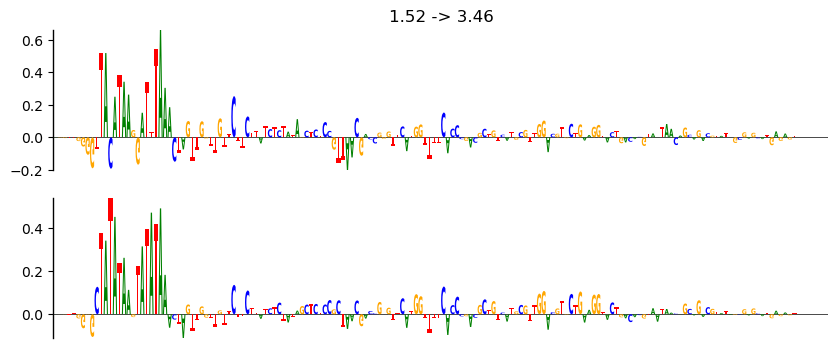

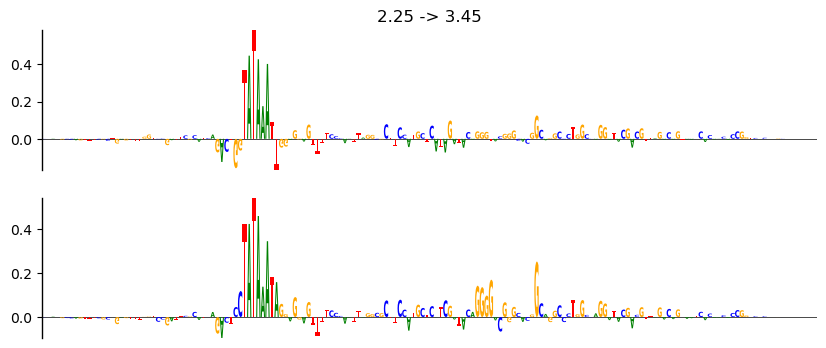

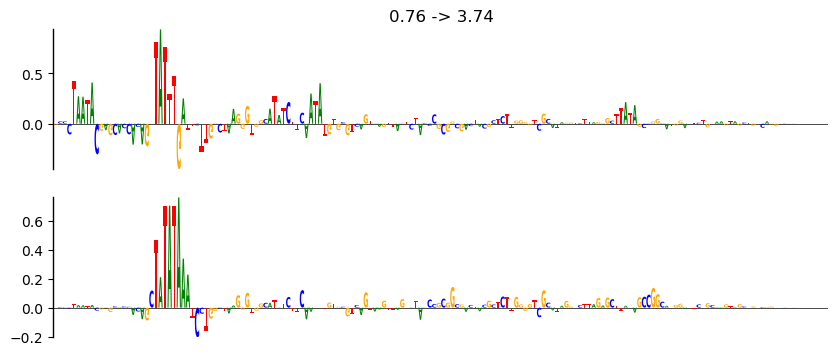

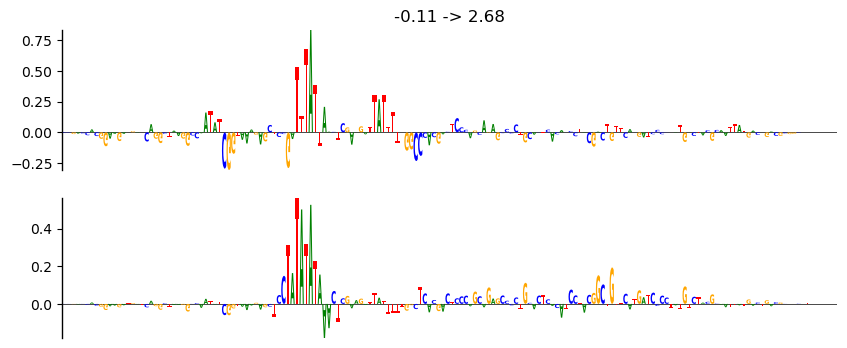

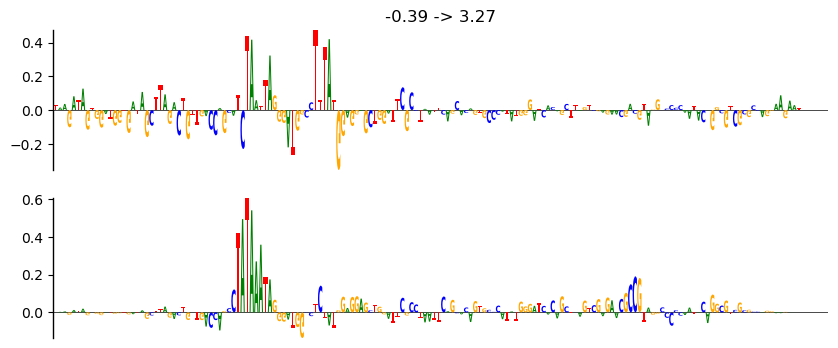

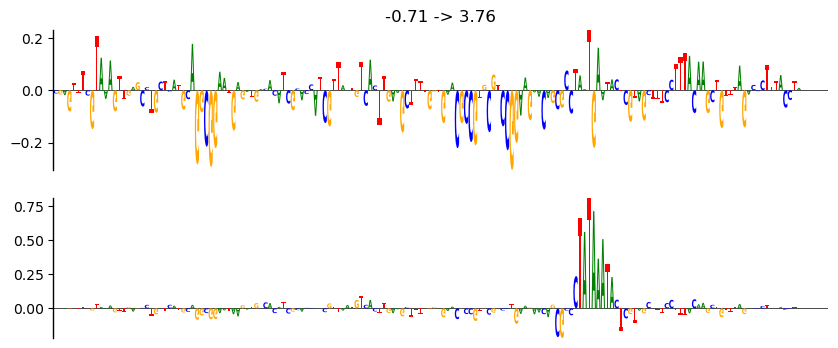

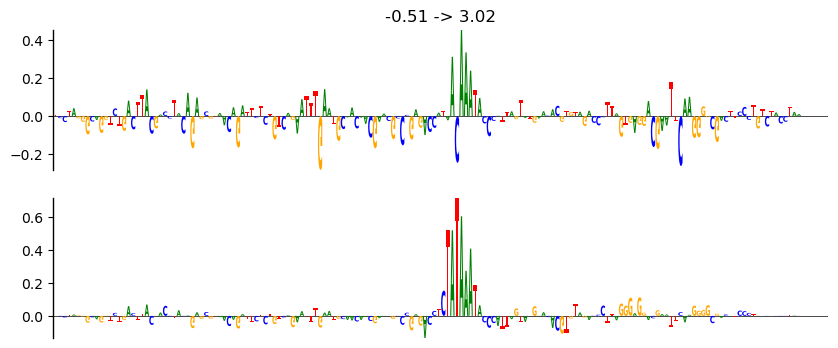

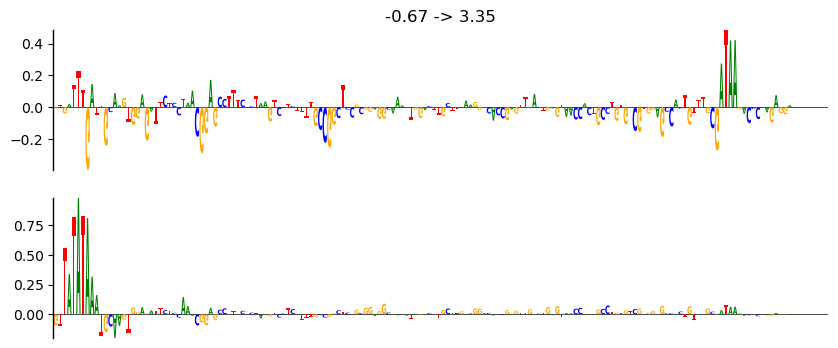

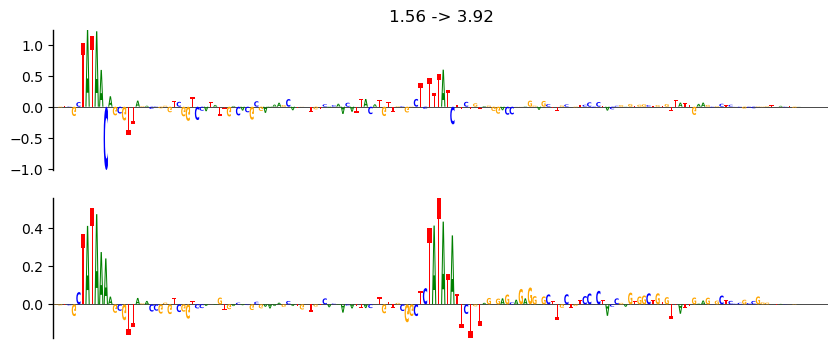

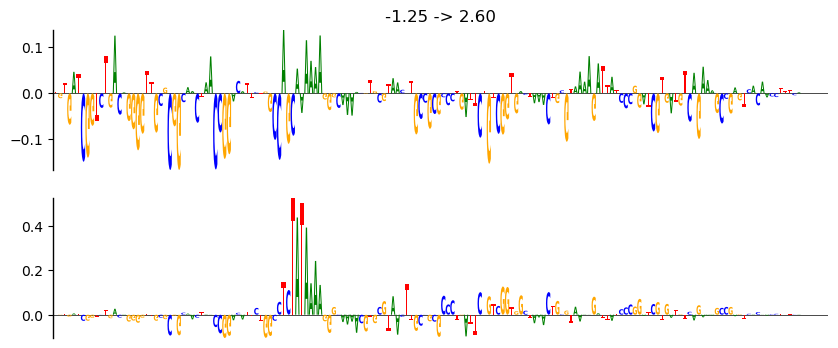

In [158]:
# Complicated plotting that we will eventually turn into a built in function
for i in tqdm(range(len(random_attrs)), desc="Plotting", total=len(random_attrs)):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    random_viz_seq = pd.DataFrame(random_attrs[i].T, columns=["A", "C", "G", "T"])
    random_viz_seq.index.name = "pos"
    random_logo = lm.Logo(random_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[0])
    random_logo.style_spines(visible=False)
    random_logo.style_spines(spines=['left'], visible=True)
    random_logo.ax.set_xticks([])
    ax[0].set_title(f"{scores[0][i].item():.2f} -> {scores[5][i].item():.2f}")
    ax_bottom = ax[0].get_ylim()[0]
    evolved_viz_seq = pd.DataFrame(evolved_attrs[i].T, columns=["A", "C", "G", "T"])
    evolved_viz_seq.index.name = "pos"
    evolved_logo = lm.Logo(evolved_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[1])
    evolved_logo.style_spines(visible=False)
    evolved_logo.style_spines(spines=['left'], visible=True)
    evolved_logo.ax.set_xticks([])

Unsurprisingly for this model, we see that it tries to select for the presence of the TATA box in almost every case (even when one already exists). And it doesn't even seem to care if it puts them only a few nucleotides apart.

## Avoiding overinterpretation
Sequence evolution represents abother means for intepreting what features a model is learning to use to make predictions and represents an exxciting avenue for exploration. As a newer method, one should also be aware that theoretical properties of prediction evolution are not well understood and should be investigated. We hope SeqExplainer provides a useful tool for exploring this area.

# DONE!

---

# Scratch